## Age and Gender Detection System.

### In this project, we will be performing both classification and regression to predict both gender and age respectively.

In [1]:
# Import necessary modules first.
import tensorflow as tf
from tensorflow.keras.utils import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

## Load the dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!gdown --id '1NVUJrBCw4frMZhUWFc85djjj_dXt7dwC' -O UTKFace.zip
!unzip UTKFace.zip

In [4]:
BASE_DIR = '/content/UTKFace'
gender_labels = []
image_paths = []

image_filenames = os.listdir(BASE_DIR)
random.shuffle(image_filenames)

for image in tqdm(image_filenames):
  image_path = os.path.join(BASE_DIR, image)
  img_components = image.split('_')
  gender_label = int(img_components[1])

  # Append the image_path and gender_label
  gender_labels.append(gender_label)
  image_paths.append(image_path)


  0%|          | 0/23708 [00:00<?, ?it/s]

In [5]:
print(f'Number of gender_labels: {len(gender_labels)}, Number of image_paths: {len(image_paths)}')

Number of gender_labels: 23708, Number of image_paths: 23708


In [6]:
gender_mapping = {
    1: 'Female',
    0: 'Male'
}

In [7]:
import pandas as pd
df = pd.DataFrame()
df['image_path'], df['gender'] = image_paths, gender_labels
df.head(5)

,image_path,gender
0,/content/UTKFace/54_0_3_20170119210112712.jpg....,0
1,/content/UTKFace/25_1_3_20170104222459455.jpg....,1
2,/content/UTKFace/21_1_0_20170109213908912.jpg....,1
3,/content/UTKFace/18_1_0_20170109212936696.jpg....,1
4,/content/UTKFace/29_1_4_20170117202750455.jpg....,1


## Exploratory Data Anlysis

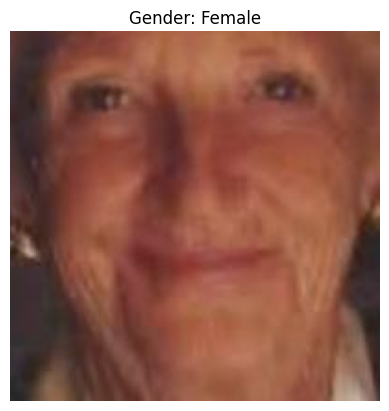

In [8]:
from PIL import Image

rand_index = random.randint(0, len(image_paths))
gender = df['gender'][rand_index]
IMG = Image.open(df['image_path'][rand_index])
plt.title(f'Gender: {gender_mapping[gender]}')
plt.axis('off')
plt.imshow(IMG)


<Axes: ylabel='count'>

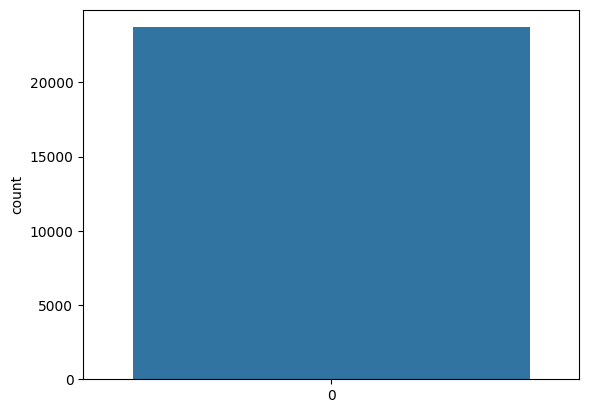

In [9]:
sns.countplot(df['gender'])

The number of samples for females are slightly higher than that of males. However, the dataset is not highly imbalanced.

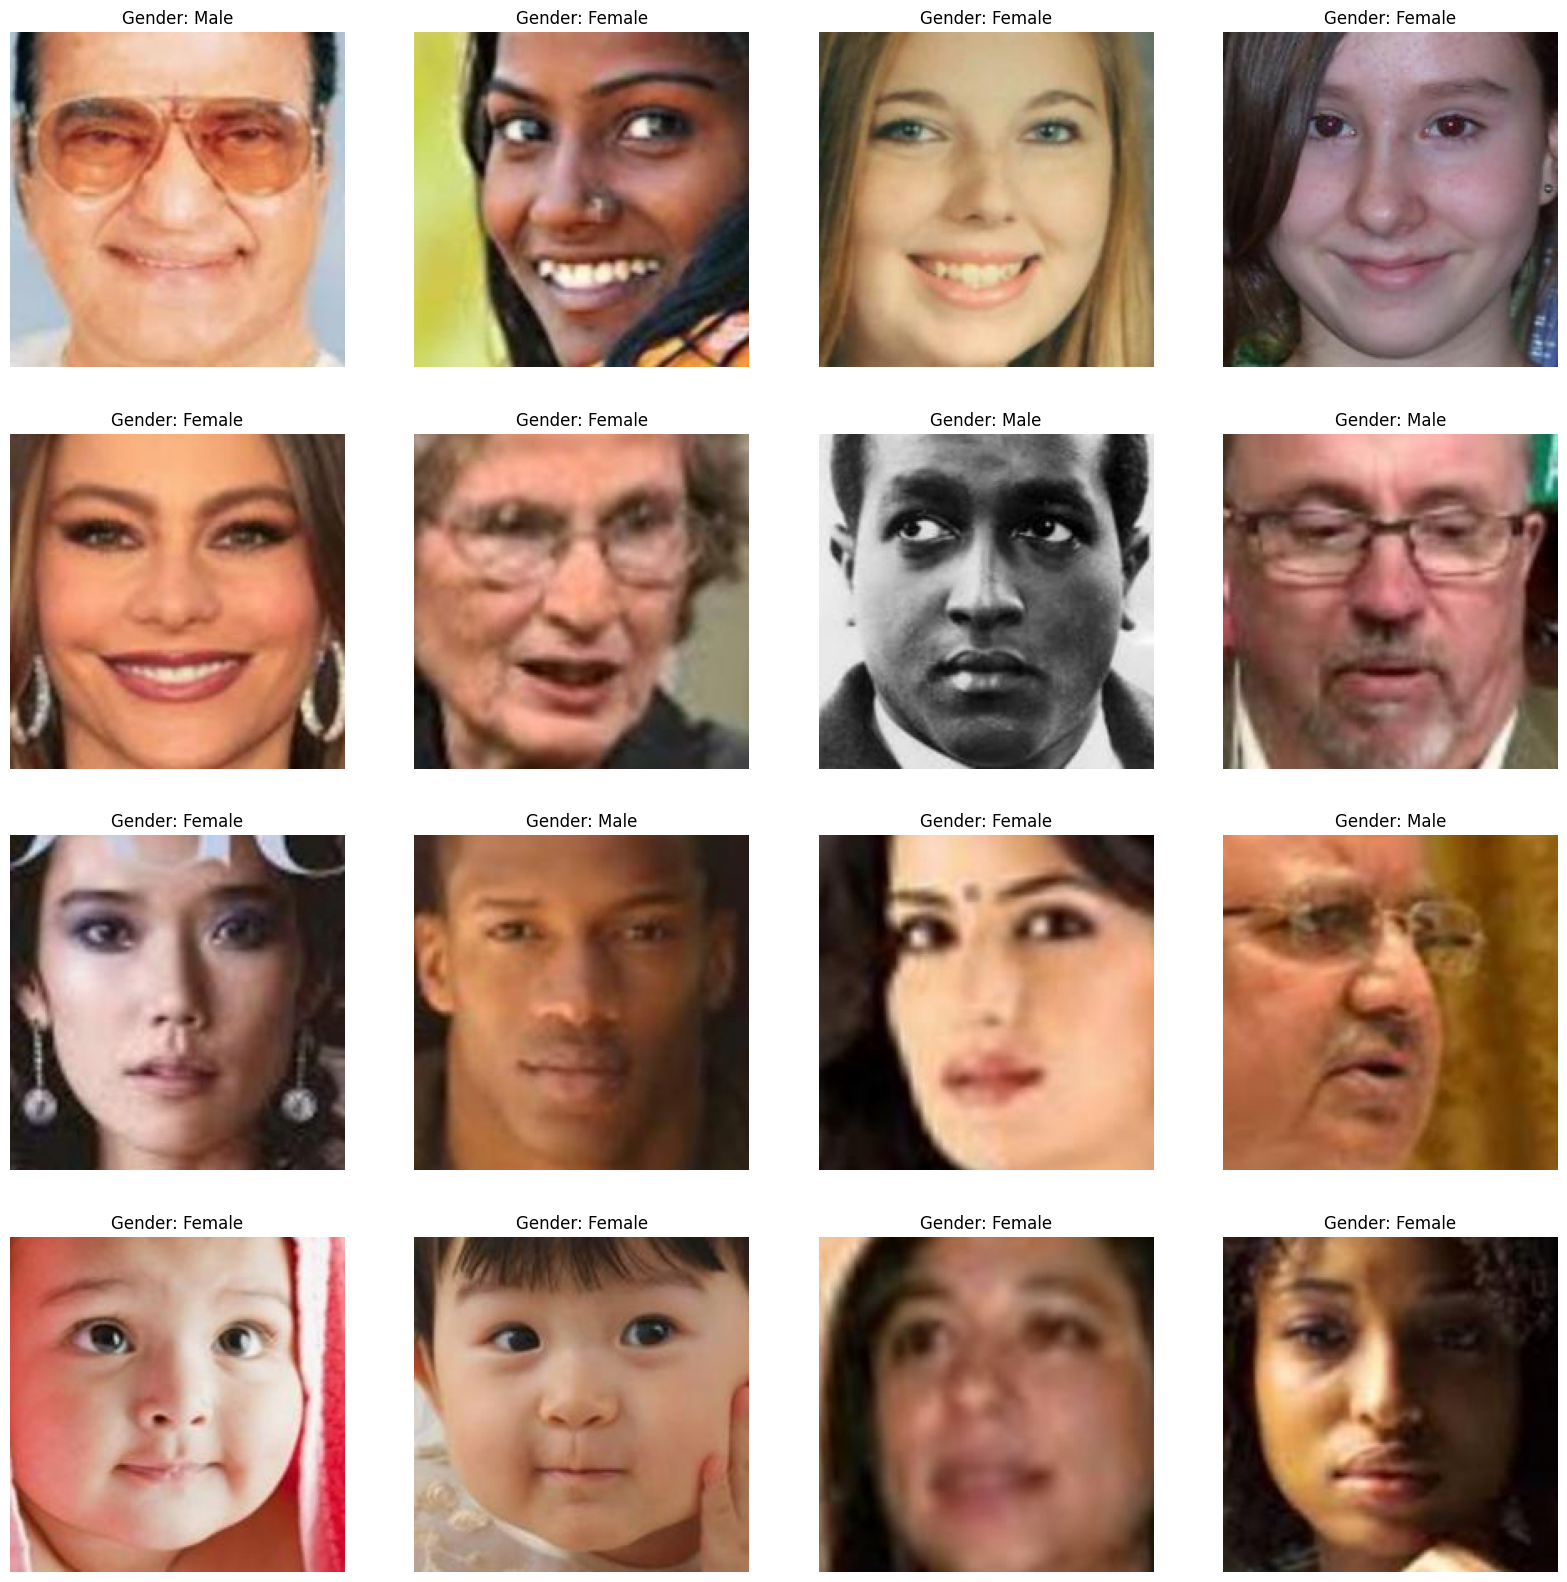

In [10]:
plt.figure(figsize=(20, 20))
samples = df.iloc[0:16]

for index, sample, gender in samples.itertuples():
    plt.subplot(4, 4, index + 1)
    img = load_img(sample)
    img = np.array(img)
    plt.axis('off')
    plt.title(f'Gender: {gender_mapping[gender]}')
    plt.imshow(img)

## Feature Extraction

In [11]:
def extract_image_features(images):
    features = list()

    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [12]:
X = extract_image_features(df['image_path'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [13]:
X.shape

(23708, 128, 128, 1)

In [14]:
X = X / 255.0

In [15]:
y_gender = np.array(df['gender'])

In [ ]:
from sklearn import svm
from sklearn.model_selection import train_test_split

# Flatten the features for SVM
X_flat = X.reshape(len(X), -1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_flat, y_gender, test_size=0.2, random_state=42)

# Create a SVM classifier
clf = svm.SVC()

# Train the model
clf.fit(X_train, y_train)

# Evaluate the model
print('Train accuracy:', clf.score(X_train, y_train))
print('Test accuracy:', clf.score(X_test, y_test))


In [ ]:
import joblib

# Save the model
joblib.dump(clf, 'svm_gender.pkl')

# Copy the model to your Google Drive
!cp -r ./svm_gender.pkl /content/drive/MyDrive/CV2/

## Plot Results

In [ ]:
from sklearn import svm
from sklearn.model_selection import cross_val_score

# Create a SVM classifier
clf = svm.SVC()

# Perform 5-fold cross validation
scores = cross_val_score(clf, X_train, y_train, cv=5)

print("Cross-validation scores: ", scores)
print("Mean cross-validation score: ", scores.mean())


## Predicting Test Data

In [ ]:
def get_image_features(image):
  img = load_img(image, grayscale=True)
  img = img.resize((128, 128), Image.ANTIALIAS)
  img = np.array(img)
  img = img.reshape(1, -1)  # Flatten the image for SVM
  img = img / 255.0
  return img

In [ ]:
img_to_test = '/content/drive/MyDrive/Projects/CodeClause Projects/Age and Gender Detection System/test images/1.png'
features = get_image_features(img_to_test)

# Predict the gender using the SVM model
pred = clf.predict(features)
gender = gender_mapping[pred[0]]

plt.title(f'Predicted Gender: {gender}')
plt.axis('off')
plt.imshow(np.array(load_img(img_to_test)))

In [ ]:
import urllib.request
import cv2
import numpy as np
from joblib import load
import matplotlib.pyplot as plt

# URL of the Haar Cascade model
url = "https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml"

# Path to save the model
save_path = "haarcascade_frontalface_default.xml"

# Download and save the model
urllib.request.urlretrieve(url, save_path)

In [ ]:
# Load the pre-trained models
face_detector = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
svm_gender = load('drive/MyDrive/CV/svm_gender.pkl')  # replace with the path to your SVM model

# Load the image
image = cv2.imread('R.jpg')

# Detect faces in the image
faces = face_detector.detectMultiScale(image, 1.1, 4)

In [ ]:

# Initialize counters
male_count = 0
female_count = 0

# Loop over the faces
for (x, y, w, h) in faces:
    # Extract the face
    face = cv2.resize(image[y:y+h, x:x+w], (128, 128))

    # Convert the face to grayscale
    face_gray = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)

    # Flatten and normalize the face image to match the format of the training data
    face_flattened = face_gray.flatten().reshape(1, -1)
    face_normalized = face_flattened / 255.0

    # Predict the gender of the face
    prediction = svm_gender.predict(face_normalized)

    # Update the counters
    if prediction[0] == 0:  # assuming that '0' is the label for male
        male_count += 1
    else:
        female_count += 1

    # Display the resized face and the prediction
    plt.imshow(face_gray, cmap='gray')
    plt.title(f'Predicted gender: {"Male" if prediction[0] == 0 else "Female"}')
    plt.show()

# Print the results
print(f'Number of males: {male_count}')
print(f'Number of females: {female_count}')

# Display the image with detected faces
image_copy = image.copy()  # create a copy of the image to display the detected faces
for (x, y, w, h) in faces:
    # Draw a rectangle around the detected face
    cv2.rectangle(image_copy, (x, y), (x+w, y+h), (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB))
plt.title('Image with Detected Faces')
plt.show()